In [62]:
##PAIRS TRADING DEMOSTRATION
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.ndimage import shift
import matplotlib.dates as mdates


from tqdm import tqdm
from joblib import Parallel, delayed

# import cupy as cp
# from numba import cuda
# import numba
# import math
# import yfinance as yf


Things to do
- Pair breakage

QUESTIONS TO BACKTEST
- When the spread closes?

The following parameters remain to be calibrated by backtesting:

1. Stop loss when spread beyond 2-3 SD?
2. Capital allocation methodology between different viable pairs versus how much cash we keep
3. 2.5 s.d. close out  parameter
4. Exit condition


In [63]:
n_jobs = -1  # Use all available CPU cores

In [64]:
# os.chdir("c:\\smu")

start_train_date = '2019-06-01'
end_train_date = '2023-05-31'
start_test_date = '2023-06-01'
end_test_date = '2024-05-31'


#======= SPY constituents Pairs Trading ============================#
# spy_df = pd.read_csv(f"spy500pvdata_{start_train_date}.csv", on_bad_lines='skip')
# spy_df = pd.read_csv(f"SPY_holdings_{start_train_date}.csv", on_bad_lines='skip')
spy_df = pd.read_csv(f"SPY_cleaned_data.csv", on_bad_lines='skip')

spy_df

,date,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,2010-03-22,24.120173,7.270,8.026786,35.120,144.71,25.846827,8.351111,42.430,34.95,...,83.73510,44.960,76.54,21.50,66.97,24.250,27.426311,56.504852,30.1300,31.0100
1,2010-03-23,24.399141,7.390,8.155714,35.120,144.71,26.072332,8.362222,42.400,35.22,...,84.55629,45.320,76.33,21.30,66.95,24.250,27.498203,56.757282,29.9500,31.0100
2,2010-03-24,24.248926,7.410,8.191786,35.120,144.71,25.846827,8.384444,41.790,36.51,...,83.52318,45.000,75.81,21.08,66.50,24.250,27.260963,56.359222,29.4100,31.0100
3,2010-03-25,24.713877,7.370,8.094643,35.120,144.71,25.678896,8.362222,41.520,35.87,...,84.45033,44.160,74.41,21.06,66.30,24.250,27.354422,55.805824,29.0300,31.0100
4,2010-03-26,24.542204,7.300,8.246429,35.120,144.71,25.381420,8.365556,42.400,35.51,...,84.34437,44.300,76.63,21.04,66.54,24.250,27.512580,55.640778,29.3200,31.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3575,2024-06-04,130.850000,11.500,194.350000,162.140,147.08,103.430000,100.860000,288.060,448.37,...,255.18000,29.470,92.92,56.03,112.67,137.100,141.540000,113.440000,302.7700,171.8800
3576,2024-06-05,133.560000,11.620,195.870000,165.440,145.78,103.230000,99.680000,291.020,455.80,...,253.61000,29.450,93.36,55.16,113.12,139.670,140.530000,112.640000,307.5000,175.8200
3577,2024-06-06,132.820000,11.430,194.480000,168.570,147.00,104.270000,100.080000,291.740,458.13,...,254.52000,29.760,92.48,54.82,113.97,136.870,140.830000,113.370000,307.4900,176.7800
3578,2024-06-07,132.980000,11.500,196.890000,169.420,146.66,107.580000,100.570000,288.400,465.43,...,255.49000,29.360,93.14,54.74,112.75,137.320,139.970000,113.340000,300.8300,176.9200


In [65]:
# Cleaning data
pivoted_data = spy_df.copy()
# Convert date column to datetime
pivoted_data['date'] = pd.to_datetime(pivoted_data['date'], format='%Y-%m-%d')

# Ensure the date is a datetime object and set as index
pivoted_data = pivoted_data.set_index('date')
pivoted_data.index = pd.to_datetime(pivoted_data.index, format='%Y-%m-%d')

# Sort by date just in case
pivoted_data = pivoted_data.sort_index()

# Handle missing values
pivoted_data = pivoted_data.ffill().bfill()

# Drop rows after 2024-05-31 based on the index (date)
cutoff_date = pd.to_datetime(end_test_date)
pivoted_data = pivoted_data.loc[:cutoff_date]

test_range = pivoted_data.copy()
testing_data = test_range[start_test_date:end_test_date]

training_data = pivoted_data[start_train_date:end_train_date]
training_data.to_csv('SPY_training_data.csv')
training_data


,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-03,66.99,27.20,43.3250,75.70,144.71,75.71,34.96,175.16,259.03,96.07,...,178.06,22.90,103.57,57.95,71.88,75.72,104.11,110.970870,167.69,103.95
2019-06-04,67.95,29.12,44.9100,76.75,144.71,77.46,34.88,177.97,268.71,100.97,...,179.22,23.42,112.87,57.78,73.59,77.40,106.97,113.990290,177.08,108.12
2019-06-05,68.35,30.36,45.6350,77.06,144.71,78.69,35.40,179.56,272.86,99.87,...,182.85,23.34,110.46,59.32,72.98,78.88,107.29,115.087380,181.59,108.50
2019-06-06,69.16,30.38,46.3050,77.07,144.71,80.09,35.58,180.40,274.80,99.97,...,183.47,23.10,109.98,59.80,74.31,79.15,108.42,116.805824,181.76,108.89
2019-06-07,69.52,30.92,47.5375,77.43,144.71,80.74,35.64,182.92,278.16,100.69,...,186.88,23.79,111.02,59.43,74.58,79.56,109.07,117.213590,188.37,110.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,120.99,13.80,171.8400,141.15,105.71,104.04,71.77,286.82,365.76,173.20,...,220.62,28.59,101.09,65.13,107.59,101.06,130.87,128.620000,261.39,169.14
2023-05-25,119.49,14.38,172.9900,138.62,104.42,102.14,72.38,291.76,392.06,172.39,...,219.59,28.44,101.02,64.29,105.66,98.89,130.26,127.800000,259.69,165.24
2023-05-26,120.42,14.35,175.4300,137.56,106.81,102.87,71.00,303.60,415.39,176.53,...,221.02,28.25,101.13,64.32,104.97,98.35,129.86,127.650000,264.72,164.74


In [66]:
testing_data

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,116.26,14.70,180.09,133.44,112.16,102.82,69.67,305.20,426.75,180.41,...,220.22,28.54,96.48,63.55,103.36,102.13,132.25,127.36,266.20,166.00
2023-06-02,118.22,14.87,180.95,136.87,118.06,104.20,70.90,311.39,436.37,179.80,...,224.53,28.83,100.35,63.14,105.76,105.06,134.53,129.81,278.01,171.88
2023-06-05,118.35,14.81,179.58,136.86,115.69,103.76,71.30,304.45,434.18,174.98,...,223.67,28.36,100.57,63.95,105.29,106.16,134.17,130.47,269.11,171.12
2023-06-06,117.44,14.93,179.21,135.43,117.30,102.62,71.20,308.04,432.89,177.97,...,224.23,28.94,102.74,63.56,106.15,106.29,132.88,130.27,270.10,170.14
2023-06-07,116.59,15.16,177.82,136.50,116.55,101.66,71.25,311.03,418.32,180.37,...,224.51,29.48,103.26,64.31,108.53,107.08,132.44,133.07,277.56,163.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,150.66,13.84,189.98,157.06,144.47,103.95,103.36,300.99,475.43,232.51,...,253.20,30.20,94.62,53.72,113.42,144.25,137.65,116.41,327.00,170.07
2024-05-28,148.21,13.44,189.99,155.34,147.01,101.95,102.25,297.73,478.43,233.44,...,250.63,29.76,93.51,53.74,114.86,140.36,135.86,116.33,326.24,171.30
2024-05-29,145.48,11.62,190.29,154.79,146.61,100.73,101.55,293.77,477.60,228.15,...,249.68,29.36,92.53,53.30,113.63,137.95,134.67,115.14,316.93,170.80


In [67]:
# Daily returns
def calculate_daily_returns(cleaned_data):
    # Calculate daily returns
    return (cleaned_data / cleaned_data.shift(1)) - 1
# Daily returns
return_df = calculate_daily_returns(training_data)
return_df

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04,0.014330,0.070588,0.036584,0.013871,0.000000,0.023115,-0.002288,0.016042,0.037370,0.051004,...,0.006515,0.022707,0.089794,-0.002934,0.023790,0.022187,0.027471,0.027209,0.055996,0.040115
2019-06-05,0.005887,0.042582,0.016143,0.004039,0.000000,0.015879,0.014908,0.008934,0.015444,-0.010894,...,0.020254,-0.003416,-0.021352,0.026653,-0.008289,0.019121,0.002991,0.009624,0.025469,0.003515
2019-06-06,0.011851,0.000659,0.014682,0.000130,0.000000,0.017791,0.005085,0.004678,0.007110,0.001001,...,0.003391,-0.010283,-0.004345,0.008092,0.018224,0.003423,0.010532,0.014932,0.000936,0.003594
2019-06-07,0.005205,0.017775,0.026617,0.004671,0.000000,0.008116,0.001686,0.013969,0.012227,0.007202,...,0.018586,0.029870,0.009456,-0.006187,0.003633,0.005180,0.005995,0.003491,0.036367,0.010745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,-0.059468,-0.019190,0.001632,-0.009613,-0.005082,-0.016077,-0.019134,-0.004443,-0.012580,-0.078331,...,-0.003568,-0.020555,-0.007754,-0.007013,0.011184,-0.029576,-0.004412,-0.013045,-0.036244,-0.020444
2023-05-25,-0.012398,0.042029,0.006692,-0.017924,-0.012203,-0.018262,0.008499,0.017223,0.071905,-0.004677,...,-0.004669,-0.005247,-0.000692,-0.012897,-0.017938,-0.021472,-0.004661,-0.006375,-0.006504,-0.023058
2023-05-26,0.007783,-0.002086,0.014105,-0.007647,0.022888,0.007147,-0.019066,0.040581,0.059506,0.024015,...,0.006512,-0.006681,0.001089,0.000467,-0.006530,-0.005461,-0.003071,-0.001174,0.019369,-0.003026


In [68]:
test_returns_df = calculate_daily_returns(testing_data)
test_returns_df

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-02,0.016859,0.011565,0.004775,0.025704,0.052603,0.013422,0.017655,0.020282,0.022542,-0.003381,...,0.019571,0.010161,0.040112,-0.006452,0.023220,0.028689,0.017240,0.019237,0.044365,0.035422
2023-06-05,0.001100,-0.004035,-0.007571,-0.000073,-0.020075,-0.004223,0.005642,-0.022287,-0.005019,-0.026808,...,-0.003830,-0.016302,0.002192,0.012829,-0.004444,0.010470,-0.002676,0.005084,-0.032013,-0.004422
2023-06-06,-0.007689,0.008103,-0.002060,-0.010449,0.013917,-0.010987,-0.001403,0.011792,-0.002971,0.017088,...,0.002504,0.020451,0.021577,-0.006099,0.008168,0.001225,-0.009615,-0.001533,0.003679,-0.005727
2023-06-07,-0.007238,0.015405,-0.007756,0.007901,-0.006394,-0.009355,0.000702,0.009707,-0.033658,0.013485,...,0.001249,0.018659,0.005061,0.011800,0.022421,0.007432,-0.003311,0.021494,0.027619,-0.038556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,0.000731,0.001447,0.016588,-0.007582,0.024319,-0.002686,0.014029,-0.016147,-0.016304,-0.008740,...,0.002772,0.002989,0.005633,-0.006105,-0.000793,0.003688,0.004671,0.004834,0.009072,-0.004857
2024-05-28,-0.016262,-0.028902,0.000053,-0.010951,0.017582,-0.019240,-0.010739,-0.010831,0.006310,0.004000,...,-0.010150,-0.014570,-0.011731,0.000372,0.012696,-0.026967,-0.013004,-0.000687,-0.002324,0.007232
2024-05-29,-0.018420,-0.135417,0.001579,-0.003541,-0.002721,-0.011967,-0.006846,-0.013301,-0.001735,-0.022661,...,-0.003790,-0.013441,-0.010480,-0.008188,-0.010709,-0.017170,-0.008759,-0.010230,-0.028537,-0.002919


# Functions for calculating performance / backtesting

In [69]:
def annual_returns(returns):
    num_years = len(returns) / 252
    cum_ret_final = np.prod(returns + 1)
    return (cum_ret_final ** (1 / num_years) - 1) * 100

def sharpe(returns, risk_free=0):
    adj_returns = returns - risk_free
    return (np.nanmean(adj_returns) * np.sqrt(252)) / np.nanstd(adj_returns, ddof=1)

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, None, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)

def sortino(returns, risk_free=0):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)
    if drisk == 0:
        return np.nan
    return (np.nanmean(adj_returns) * np.sqrt(252)) / drisk


def calculate_winning_percentage(daily_pnl):
    """
    Calculate the winning percentage based on the daily PnL.

    Args:
    - daily_pnl (pd.Series): Series containing the daily PnL.

    Returns:
    - int: winning days
    - int: total days
    - float: The winning percentage.
    """
    # Calculate the number of winning days
    winning_days = int((daily_pnl > 0).sum())
    
    # Total number of days
    total_days = len(daily_pnl)
    
    # Calculate winning percentage
    winning_percentage = (winning_days / total_days) * 100
    
    return winning_days, total_days, winning_percentage


def volatility(returns, annualize=True, trading_days=252):
    """
    Calculate the volatility of a time series of returns.
    
    :param returns: A pandas Series or numpy array of returns.
    :param annualize: Boolean flag to indicate whether to annualize the volatility.
    :param trading_days: The number of trading days in a year (default is 252).
    :return: The calculated volatility.
    """
    # Calculate the standard deviation of returns
    vol = np.std(returns)
    
    # Annualize the volatility if required
    if annualize:
        vol *= np.sqrt(trading_days)
    
    return vol * 100


def max_drawdown(returns):
    wealth_index = 1000*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return drawdown.min() * 100

def average_drawdown(returns):
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    return drawdown[drawdown < 0].mean() * 100 

def calculate_total_trades(spread_position):
    """
    Calculate the total number of trades based on the spread position.

    Parameters:
    - spread_position (array): Array containing the spread positions (-1, 0, 1).

    Returns:
    - total_trades (int): Total number of trades.
    """
    total_trades = 0
    prev_position = None

    for position in spread_position:
        if prev_position is not None and position != prev_position:
            total_trades += 1
        prev_position = position

    return total_trades


# Pairs Selection Part

In [70]:
cointegrated_pairs = pd.read_csv("cointegrated_pairs_Joblib.csv", on_bad_lines='skip', index_col=0)
cointegrated_pairs = cointegrated_pairs.sort_values(by=['P-Value'], ascending=False)
cointegrated_pairs = cointegrated_pairs.reset_index(drop=True)
cointegrated_pairs

,Stock1,Stock2,P-Value
0,DOW,EXPE,0.049997
1,CBRE,LYV,0.049980
2,AEE,RF,0.049974
3,CCL,MNST,0.049968
4,EXC,HSY,0.049964
...,...,...,...
6509,IR,KLAC,0.000010
6510,ES,KVUE,0.000010
6511,ATO,PYPL,0.000008
6512,DGX,MTD,0.000003


In [71]:
# Find the best cointegrated pair (lowest p-value)
best_pair = cointegrated_pairs.loc[cointegrated_pairs['P-Value'].idxmax()]

# Output results
print("Best cointegrated pair:")
# cointegrated
stock1, stock2, pvalue = best_pair
print(f"Selected pair: {stock1}, {stock2} with p-value {pvalue}")

Best cointegrated pair:
Selected pair: DOW, EXPE with p-value 0.0499967020232789


In [72]:
# dy_jh_pairs = pd.read_csv("final_pairs.csv", on_bad_lines='skip')
# stock1 = dy_jh_pairs['Stock1'][1]
# stock2 = dy_jh_pairs['Stock2'][1]
# print(stock1, stock2)
# dy_jh_pairs

In [73]:
dyon_pairs = pd.read_csv("filtered_pairs.csv", on_bad_lines='skip')
stock1 = dyon_pairs['Pair 1'][1]
stock2 = dyon_pairs['Pair 2'][1]
print(stock1, stock2)
dyon_pairs

ESS UDR


,Pair 1,Pair 2
0,MDLZ,PEP
1,ESS,UDR
2,LNT,XEL
3,AEP,CMS
4,DUK,XEL
5,BAC,PNC
6,RSG,WM
7,ED,LNT
8,MCHP,NXPI
9,COF,FITB


# hard code for testing

In [74]:
# stock1 = 'HD'
# stock2 = 'PRU'
# print(stock1, stock2)

# OLS Strategy part


## Rolling OLS window


In [75]:
# Example usage
stock1, stock2 = 'HD', 'PRU'  # Replace with your selected pair

In [82]:
window = 252
# Pair Trading Strategy using the best cointegrated pair found

# stock1, stock2, pvalue = best_pair
# print(f"Selected pair: {stock1}, {stock2} with p-value {pvalue}")
def ROLLING_OLS(stock1, stock2):
    # Define the spread and positions
    endog = training_data[stock1]
    exog = training_data[[stock2]]  # Make exog 2D
    
    # Rolling OLS regression to find the hedge ratio
    rols = RollingOLS(endog, exog, window=window)
    rres = rols.fit()
    params = rres.params.copy()
    
    params.columns = ['Hedge ratio']
    hedge_ratio = params['Hedge ratio']  # coefficient of stock2 in regression eqn
    
    # Calculate the spread
    spread = endog - hedge_ratio * exog[stock2]
    
    # Generate trading signals
    spread_mean = spread.mean()
    spread_rolling_std = spread.rolling(window).std()
    
    # Initialize spread position
    spread_position = np.zeros(len(spread), dtype=int)
    
    # Define thresholds for spread positions
    threshold1 = 0
    threshold2 = 2.5
    
    # Round the result of the multiplication to a reasonable precision
    threshold1_condition = np.round(threshold1 * spread_rolling_std, decimals=5)
    threshold2_condition = np.round(threshold2 * spread_rolling_std, decimals=5)
    
    # Assign positions based on spread conditions
    spread_position[spread > threshold1_condition] = -1  # Short position
    spread_position[spread < -threshold1_condition] = 1  # Long position
    spread_position[np.abs(spread) > threshold2_condition] = 0  # Close out the position
    
    # Shift position by 1 to avoid lookahead bias
    spread_position = np.roll(spread_position, 1)
    spread_position[0] = 0  # Ensure the first position is zero after shifting
    
    # Calculate positions for each stock
    stock1_position = spread_position
    stock2_position = spread_position * hedge_ratio * -1
    
    # Calculate daily returns    #########################################
    return_data = training_data.pct_change().shift(-1)  # Daily returns
    
    # Define trading costs
    trading_cost_per_trade = 0.0005  # Example trading cost per trade .0005
    
    # Calculate daily P&L without trading costs
    daily_pnl_without_costs = stock1_position * return_data[stock1] + stock2_position * return_data[stock2]
    
    # Convert spread_position to a pandas Series
    spread_position_series = pd.Series(spread_position, index=training_data.index)
    
    # Calculate trading costs for each trade
    trading_costs = spread_position_series.diff().abs() * trading_cost_per_trade
    trading_costs.iloc[0] = 0  # No trading cost for the first position
    
    # Cumulative trading costs
    cumulative_trading_costs = trading_costs.cumsum()
    
    # Calculate daily P&L with trading costs
    daily_pnl = daily_pnl_without_costs - trading_costs
    
    # Calculate cumulative P&L with trading costs
    cumulative_pnl = daily_pnl.cumsum()
    
    # Create a DataFrame to hold the results
    rolling_result_df = pd.DataFrame({
        'spread': spread,
        'spread_rolling_std': spread_rolling_std,
        'spread_position': spread_position,
        'hedge_ratio': hedge_ratio,
        'stock1_position': stock1_position,
        'stock2_position': stock2_position,
        'daily_pnl_without_costs': daily_pnl_without_costs,
        'trading_costs': trading_costs,
        'cumulative_trading_costs': cumulative_trading_costs,
        'daily_pnl': daily_pnl,
        'cumulative_pnl': cumulative_pnl
    })
    
    # Save the result DataFrame to a CSV file
    rolling_result_df.to_csv('selected_pair.csv')
    
    # Find the last occurrence of NaN values in the column "spread_rolling_std"
    last_nan_index = rolling_result_df['spread_rolling_std'].first_valid_index()
    print("Last occurrence of NaN values in 'spread_rolling_std':", last_nan_index)
    
    # rolling effect
    rolling_result_df = rolling_result_df.loc[last_nan_index:].copy()
    
    # Plot rolling window
    print("\n***** FINANCIAL PERFORMANCE *****\n")
    
    print(f"ROLLING OLS Regression with {window}")
    # Calculate winning percentage
    winning_days, total_days, winning_percentage = calculate_winning_percentage(rolling_result_df['daily_pnl'])
    print("\nNumber of winning days:", winning_days)
    print("Total number of days:", total_days)
    print(f"Winning percentage: {winning_percentage:.2f}%")
    
    total_trades = calculate_total_trades(rolling_result_df['spread_position'])
    print("Total number of trades:", total_trades)
    
    print(f"\nCummulative return: {rolling_result_df['cumulative_pnl'].iloc[-2]*100:.5f}")
    print(f"Sharpe ratio: {sharpe(rolling_result_df['daily_pnl']):.5f}")
    print(f"Sortino ratio: {sortino(rolling_result_df['daily_pnl']):.5f}")
    print(f"Max drawdown: {max_drawdown(rolling_result_df['daily_pnl']):.5f}")
    
    spread_beyond_threshold2 = (np.abs(rolling_result_df.spread) > threshold2 * rolling_result_df.spread_rolling_std)
    dates_beyond_threshold2 = rolling_result_df.index[spread_beyond_threshold2]
    # Plot cumulative PnL with proper date format on x-axis
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_result_df.index, rolling_result_df['cumulative_pnl'].values, label=f"{stock1}, {stock2} Pairs Trading")
    plt.title(f"{stock1}, {stock2} Pairs Trading")
    plt.twinx()
    plt.plot(rolling_result_df['spread_rolling_std'], color='red', linestyle='--', label='Rolling Window')
    plt.ylabel("Rolling Window (Std)")
    plt.legend(loc='upper right')
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    plt.show()
    
    # Plot spread with shaded areas and proper date format on x-axis
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_result_df.index, rolling_result_df.spread, color='blue', label='Spread')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero')
    
    # Shade the regions where the spread exceeds the +/- 2.5 SD threshold
    for date in dates_beyond_threshold2:
        plt.axvline(x=date, color='orange', linestyle='-', alpha=0.5)
    
    # Shade areas below and above zero line
    plt.fill_between(rolling_result_df.index, rolling_result_df.spread, 0, where=(rolling_result_df.spread <= 0), color='green', alpha=0.5)
    plt.fill_between(rolling_result_df.index, rolling_result_df.spread, 0, where=(rolling_result_df.spread > 0), color='red', alpha=0.5)
    plt.title('Spread Plot with Thresholds and Shaded Exceeding Areas')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    plt.show()
    
    rolling_result_df
    return rolling_result_df

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 232
Total number of days: 505
Winning percentage: 45.94%
Total number of trades: 23

Cummulative return: -9.45846
Sharpe ratio: -0.35536
Sortino ratio: -0.02987
Max drawdown: -17.45754


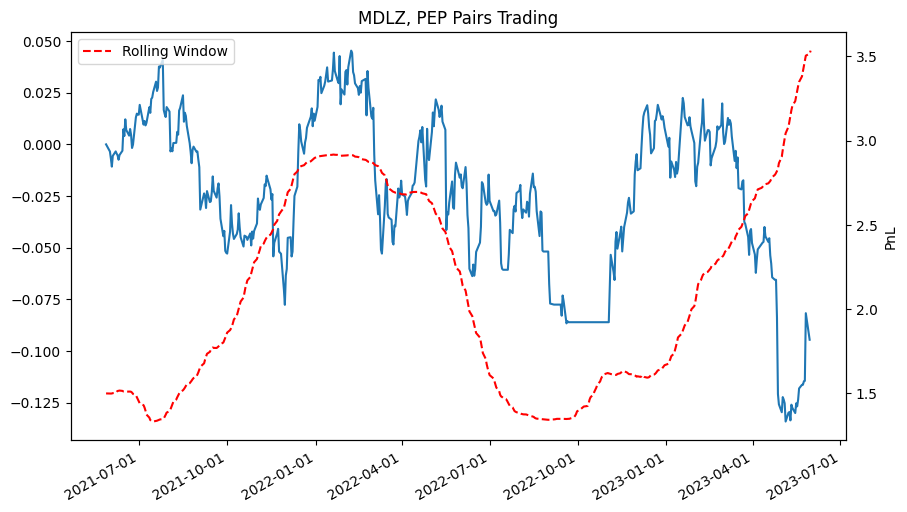

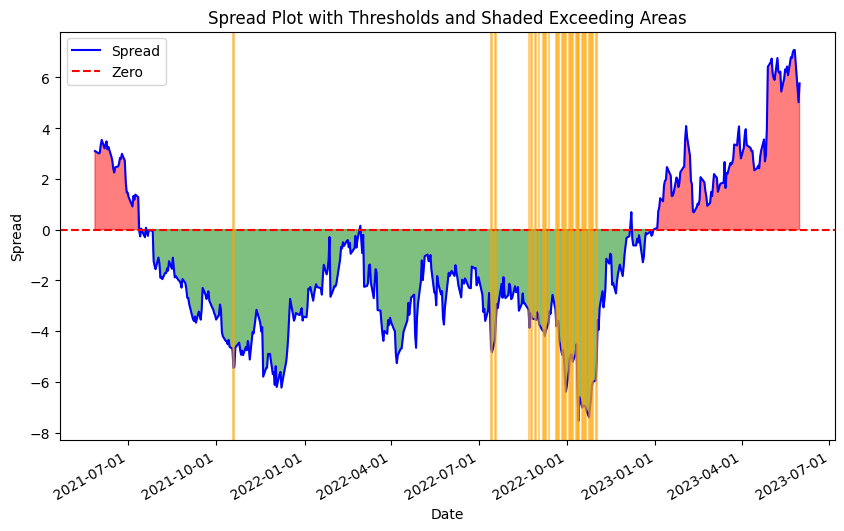

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 203
Total number of days: 505
Winning percentage: 40.20%
Total number of trades: 45

Cummulative return: -120.33908
Sharpe ratio: -0.50631
Sortino ratio: -0.04264
Max drawdown: -95.88132


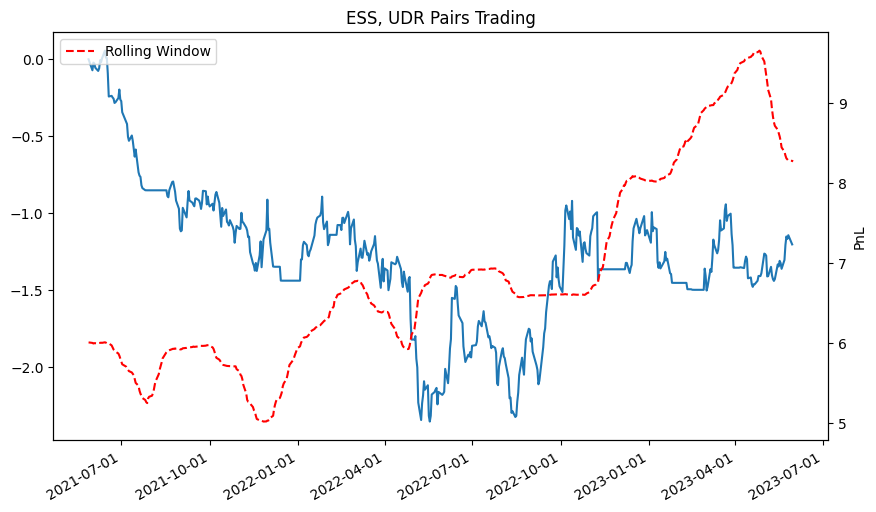

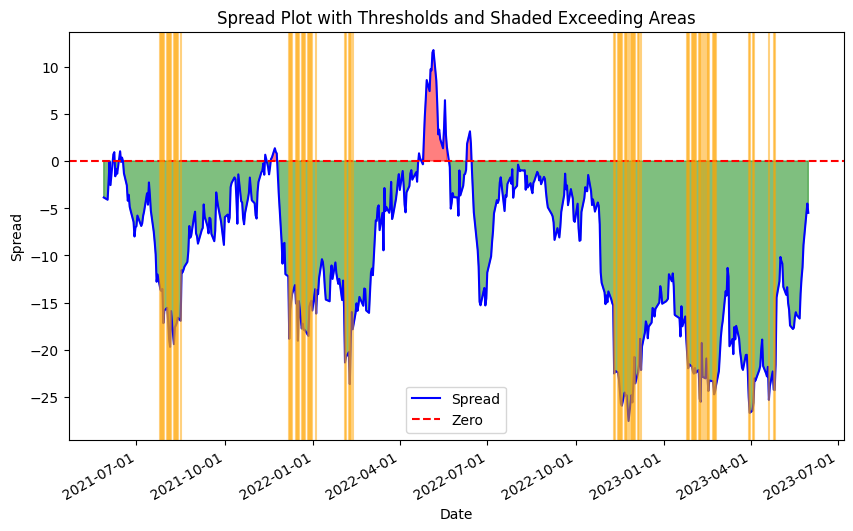

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 220
Total number of days: 505
Winning percentage: 43.56%
Total number of trades: 12

Cummulative return: -14.08253
Sharpe ratio: -0.69318
Sortino ratio: -0.06156
Max drawdown: -14.88262


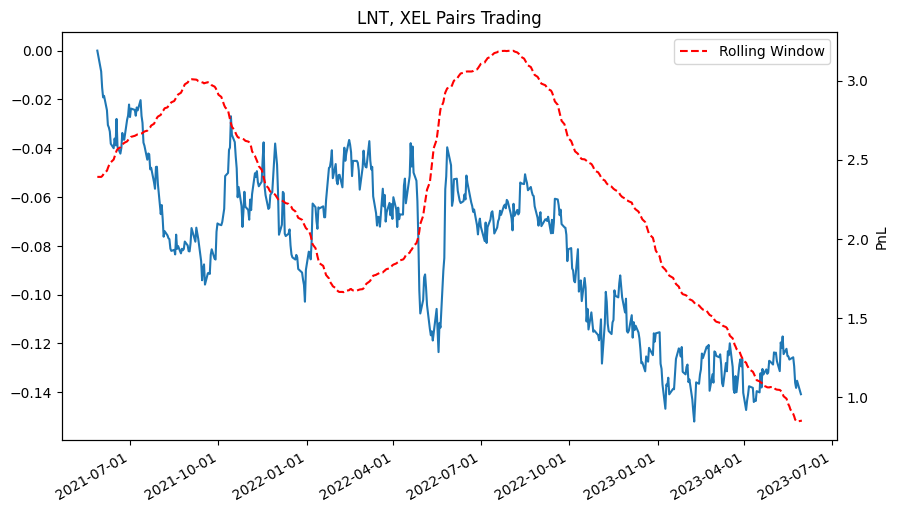

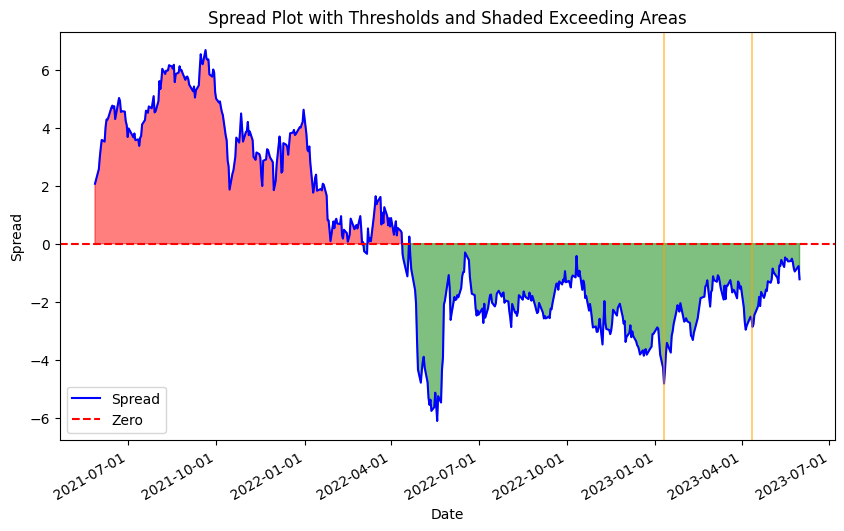

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 228
Total number of days: 505
Winning percentage: 45.15%
Total number of trades: 51

Cummulative return: -7.75719
Sharpe ratio: -0.27410
Sortino ratio: -0.02407
Max drawdown: -26.17277


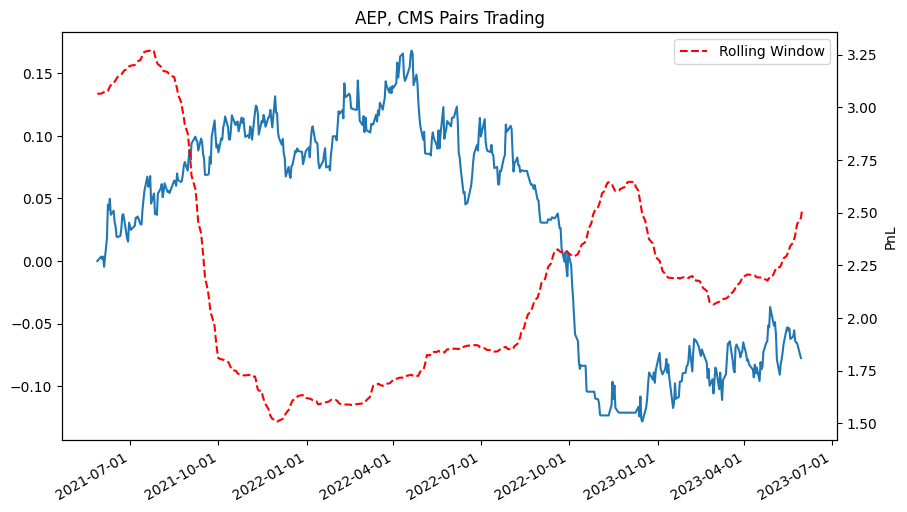

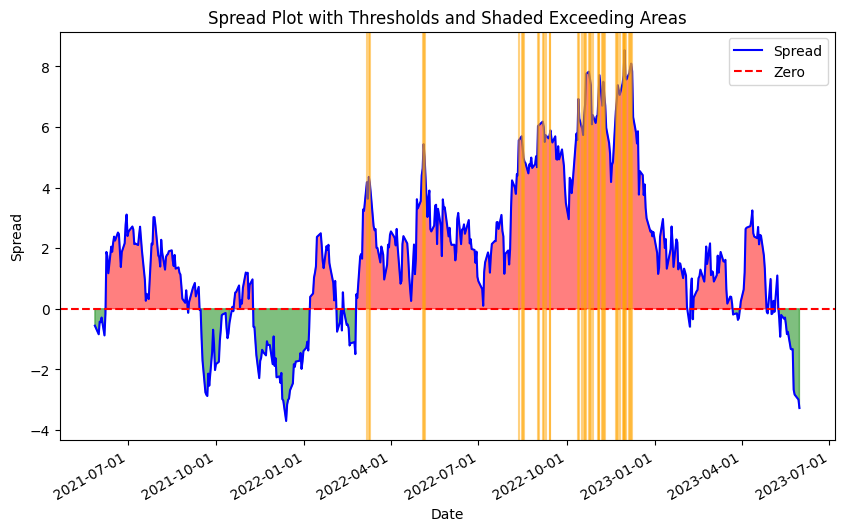

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 248
Total number of days: 505
Winning percentage: 49.11%
Total number of trades: 45

Cummulative return: 6.80048
Sharpe ratio: 0.20262
Sortino ratio: 0.01836
Max drawdown: -15.99244


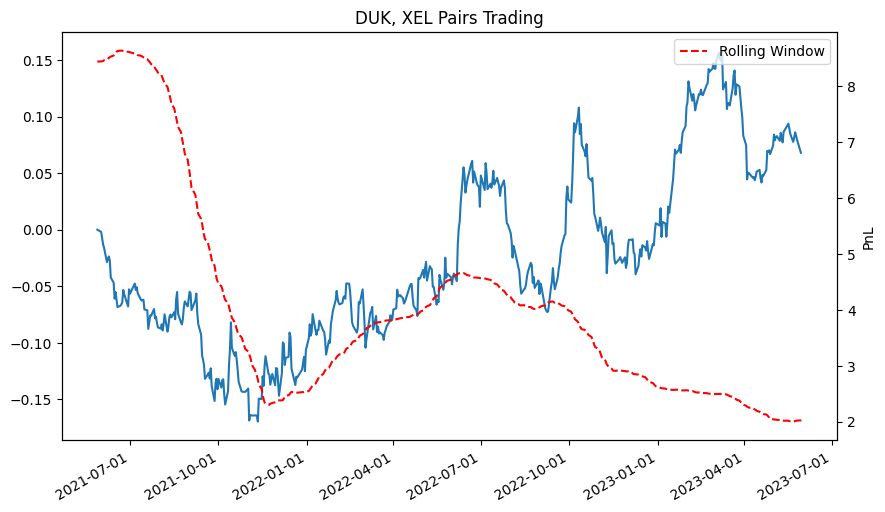

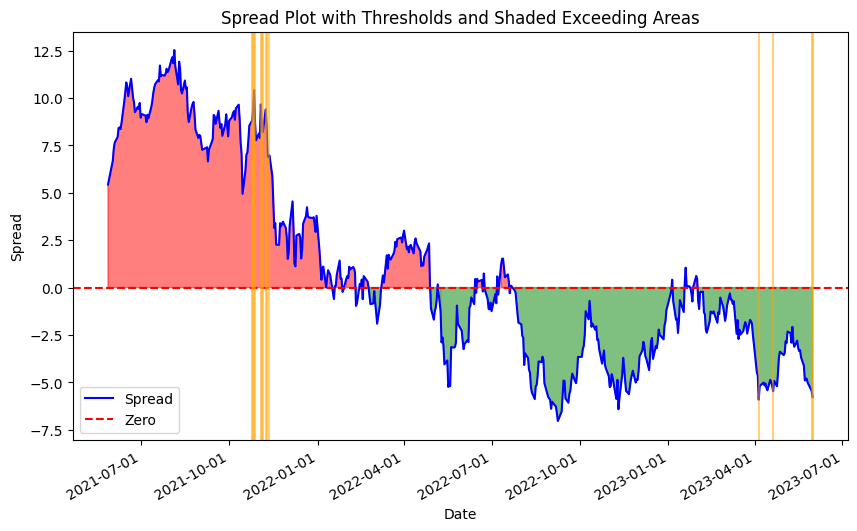

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 252
Total number of days: 505
Winning percentage: 49.90%
Total number of trades: 41

Cummulative return: 35.78534
Sharpe ratio: 0.72450
Sortino ratio: 0.07005
Max drawdown: -22.52815


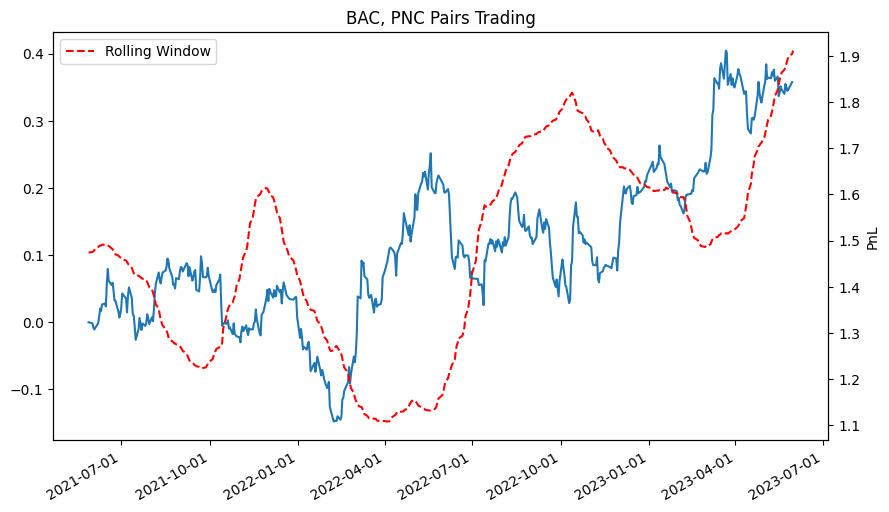

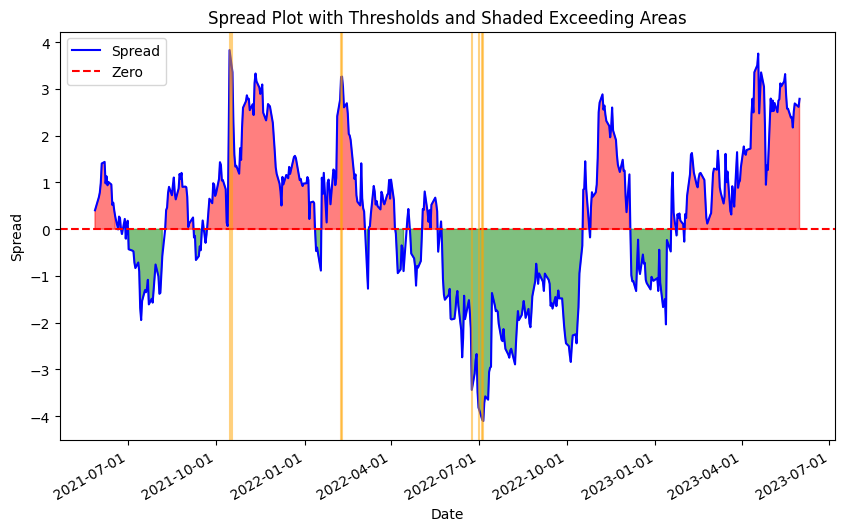

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 258
Total number of days: 505
Winning percentage: 51.09%
Total number of trades: 24

Cummulative return: -0.53174
Sharpe ratio: -0.02914
Sortino ratio: -0.00255
Max drawdown: -13.37585


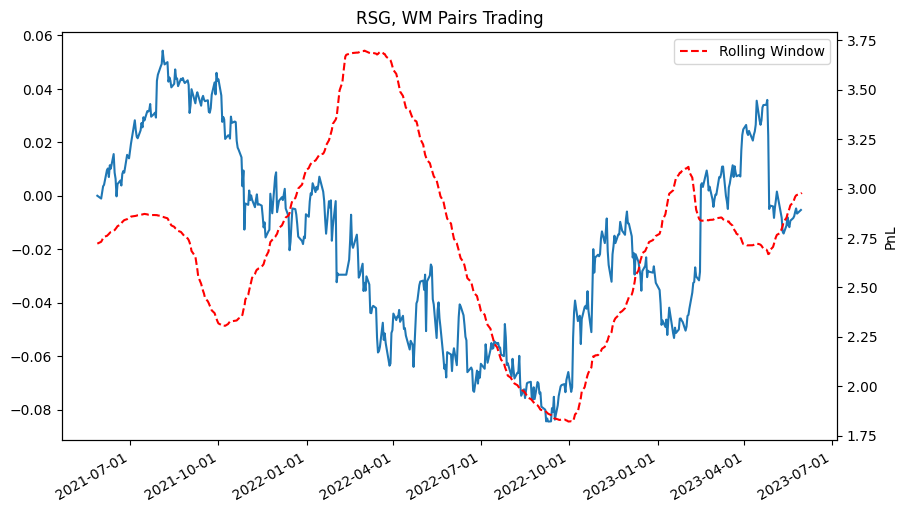

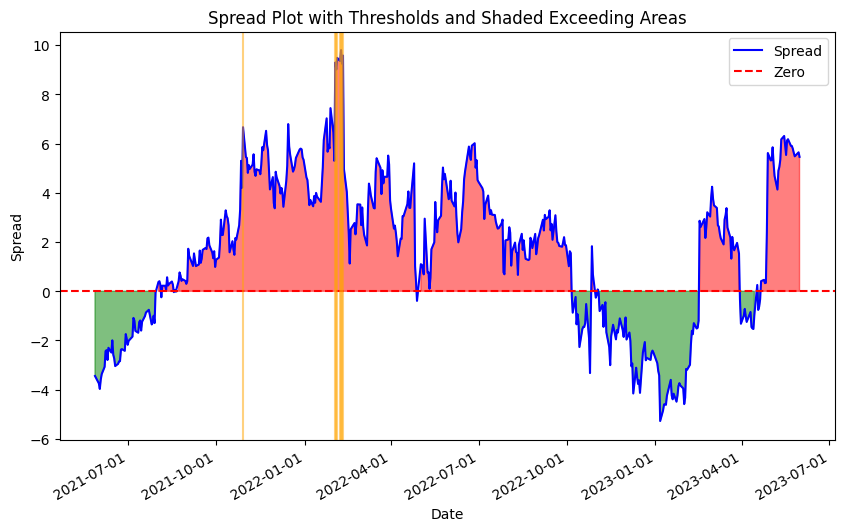

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 159
Total number of days: 505
Winning percentage: 31.49%
Total number of trades: 17

Cummulative return: -28.24879
Sharpe ratio: -0.95168
Sortino ratio: -0.08019
Max drawdown: -28.11251


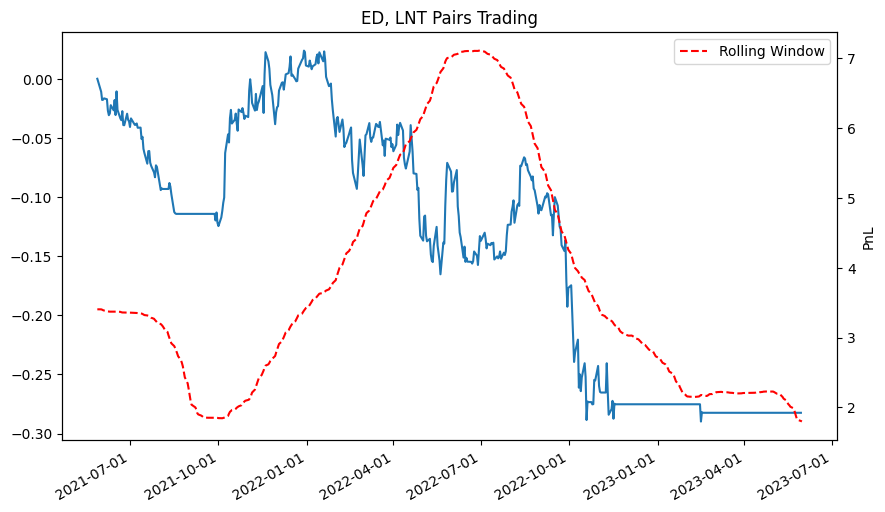

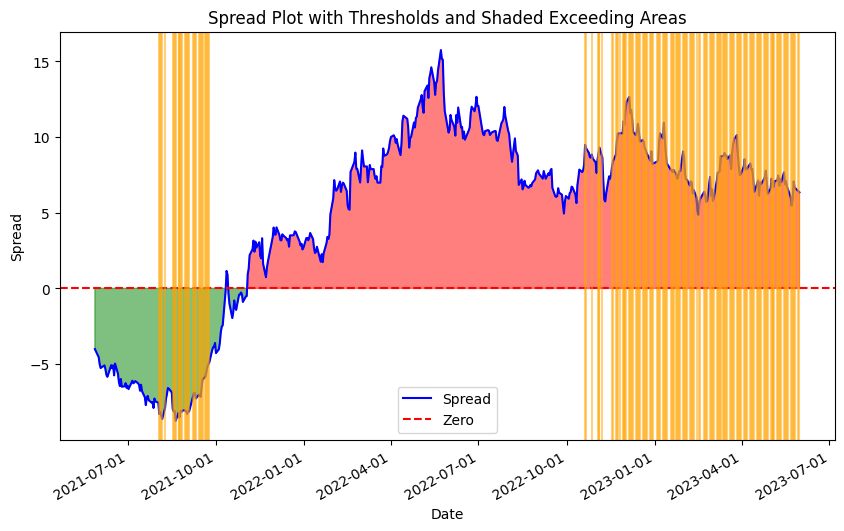

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 222
Total number of days: 505
Winning percentage: 43.96%
Total number of trades: 51

Cummulative return: -22.36521
Sharpe ratio: -0.43512
Sortino ratio: -0.03649
Max drawdown: -45.13984


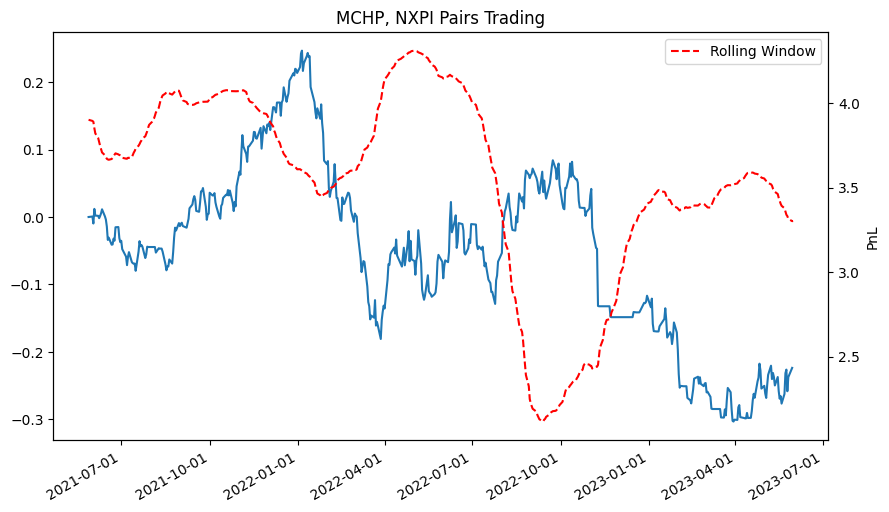

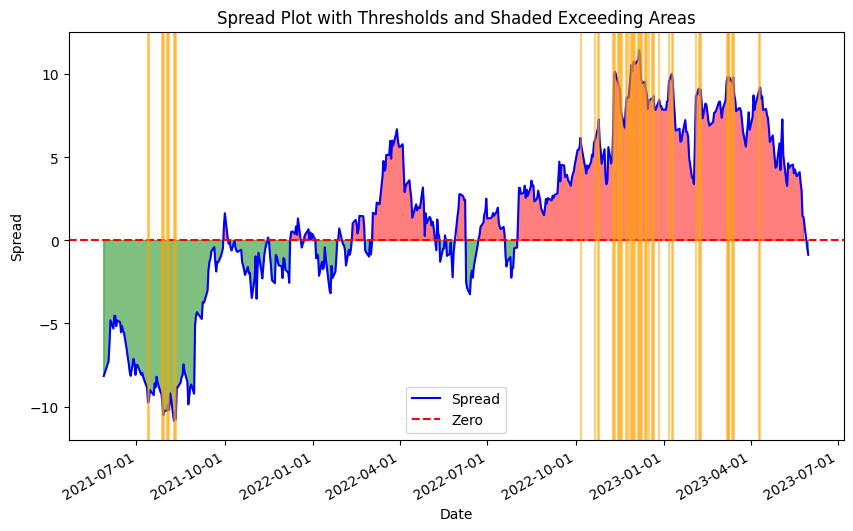

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 236
Total number of days: 505
Winning percentage: 46.73%
Total number of trades: 13

Cummulative return: 30.08095
Sharpe ratio: 0.16178
Sortino ratio: 0.01392
Max drawdown: -73.24301


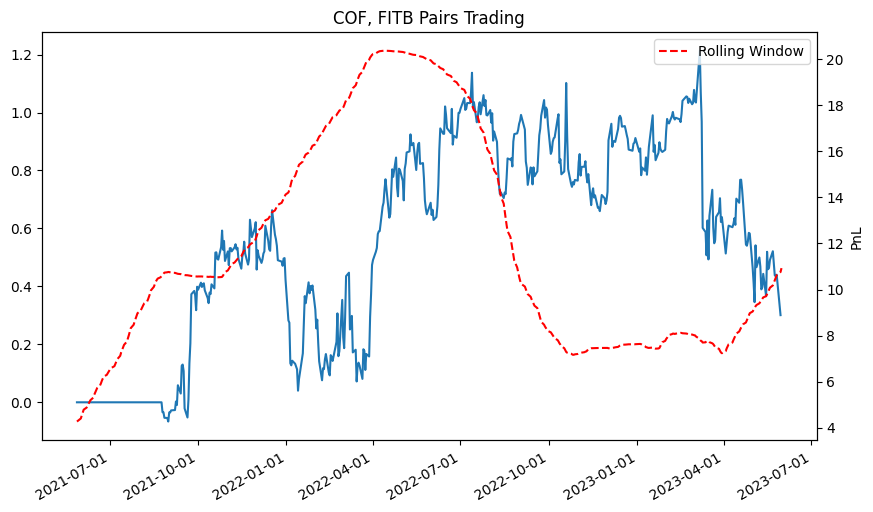

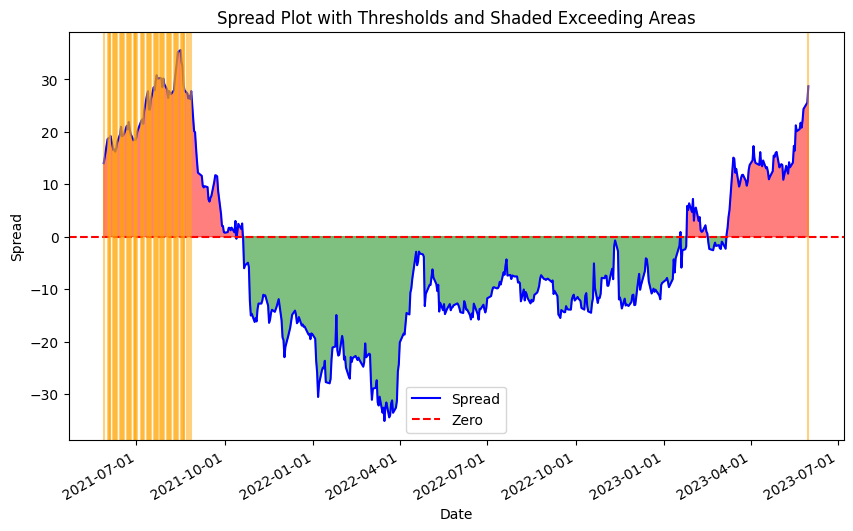

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 227
Total number of days: 505
Winning percentage: 44.95%
Total number of trades: 49

Cummulative return: -33.72605
Sharpe ratio: -0.29939
Sortino ratio: -0.02693
Max drawdown: -62.82837


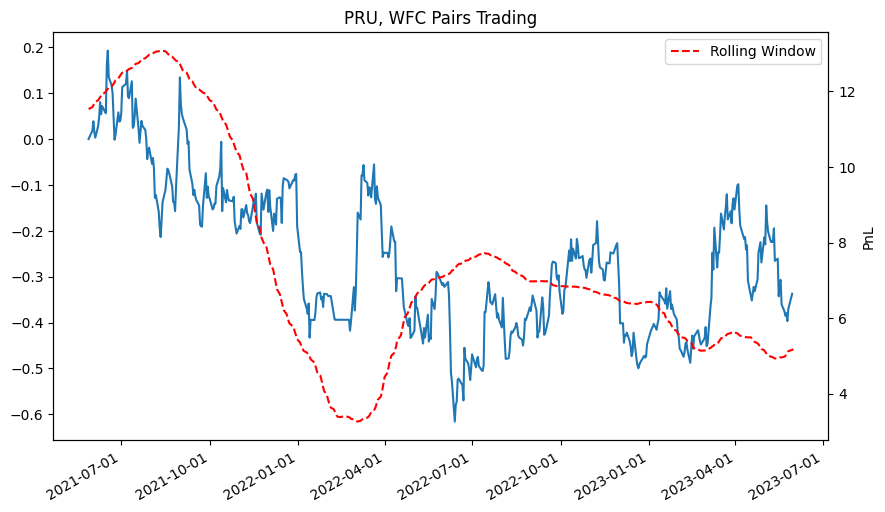

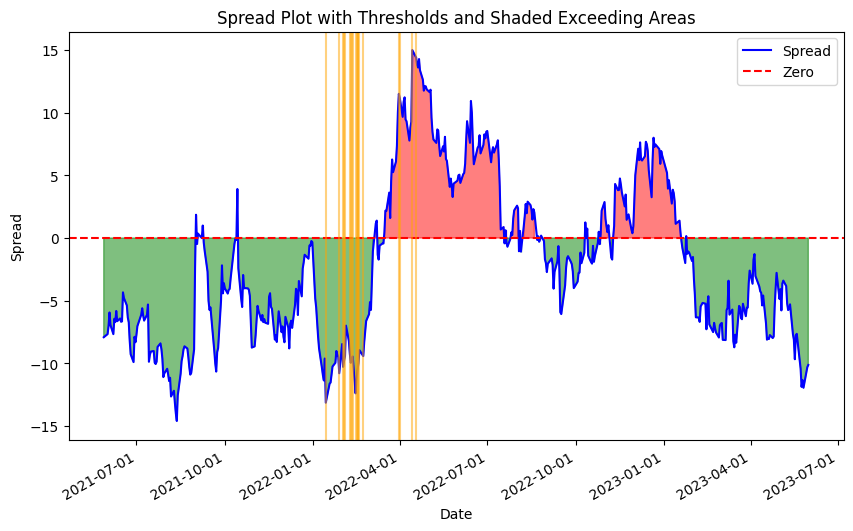

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 215
Total number of days: 505
Winning percentage: 42.57%
Total number of trades: 33

Cummulative return: -13.00529
Sharpe ratio: -0.56967
Sortino ratio: -0.05065
Max drawdown: -18.62365


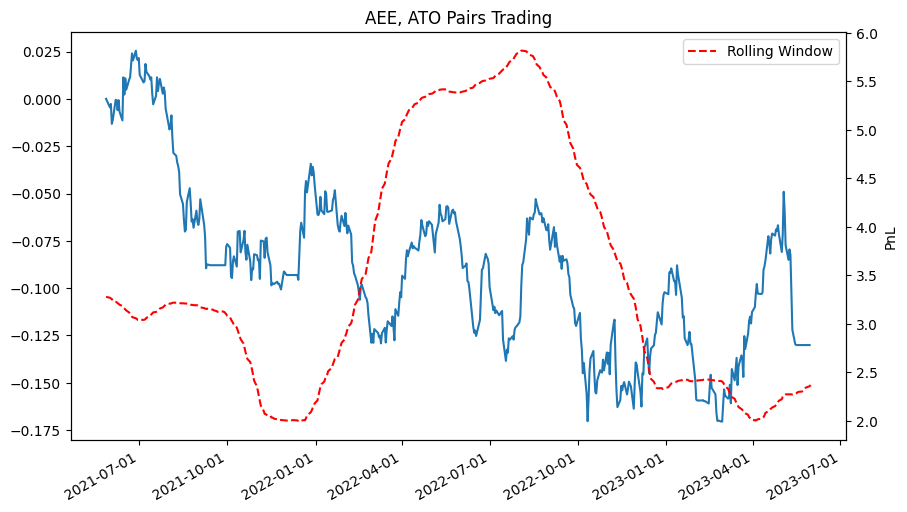

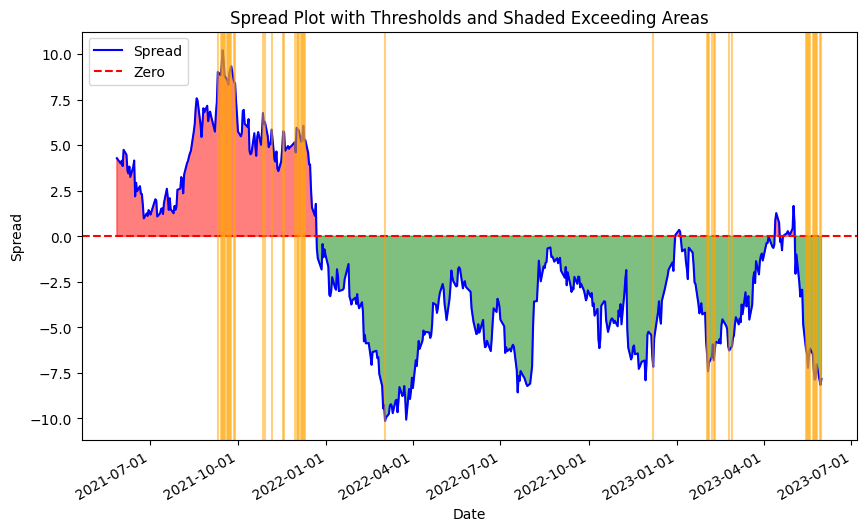

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 198
Total number of days: 505
Winning percentage: 39.21%
Total number of trades: 36

Cummulative return: 86.97180
Sharpe ratio: 0.96255
Sortino ratio: 0.09139
Max drawdown: -37.71022


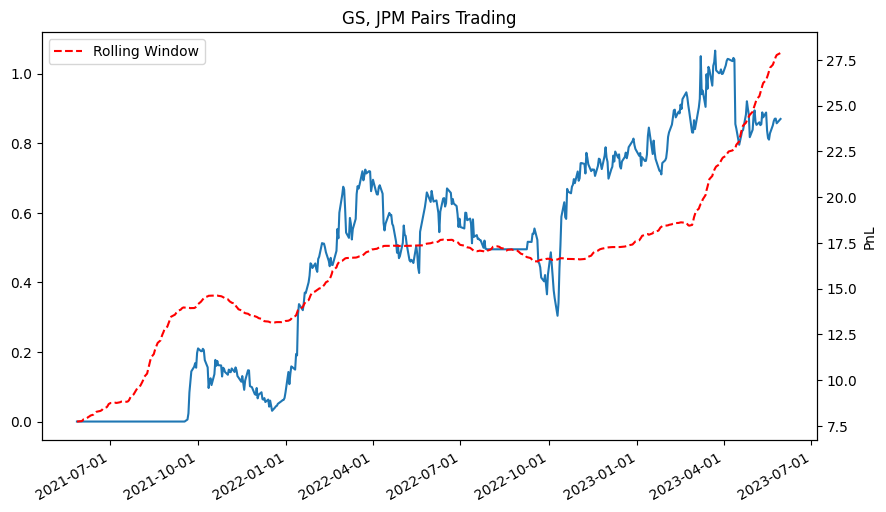

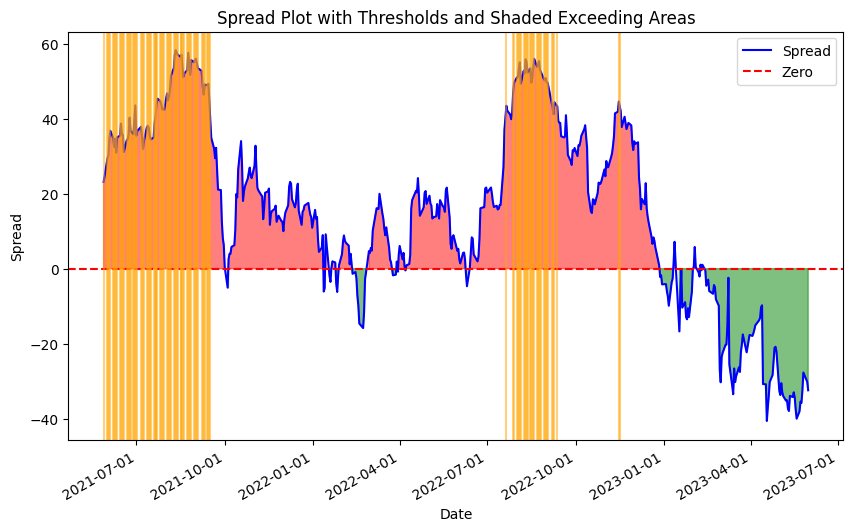

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 196
Total number of days: 505
Winning percentage: 38.81%
Total number of trades: 45

Cummulative return: 51.07083
Sharpe ratio: 0.61556
Sortino ratio: 0.05810
Max drawdown: -37.28983


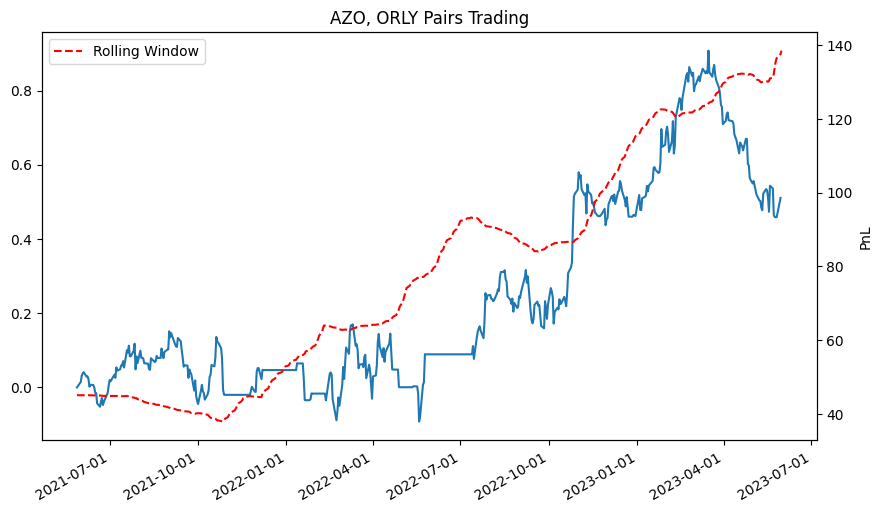

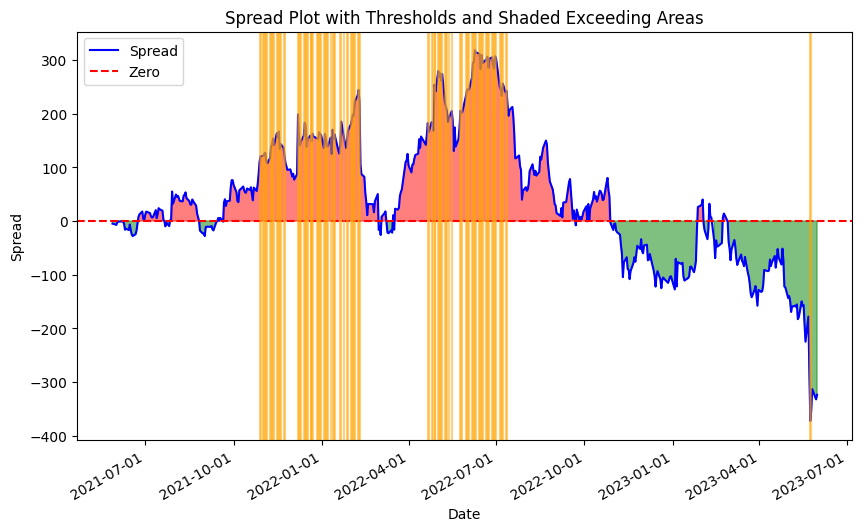

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 189
Total number of days: 505
Winning percentage: 37.43%
Total number of trades: 49

Cummulative return: -38.65347
Sharpe ratio: -1.45153
Sortino ratio: -0.12056
Max drawdown: -38.42499


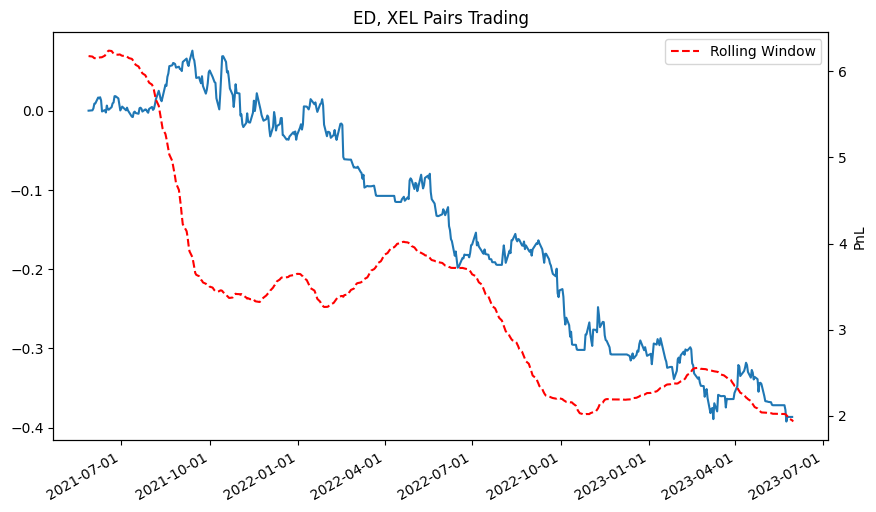

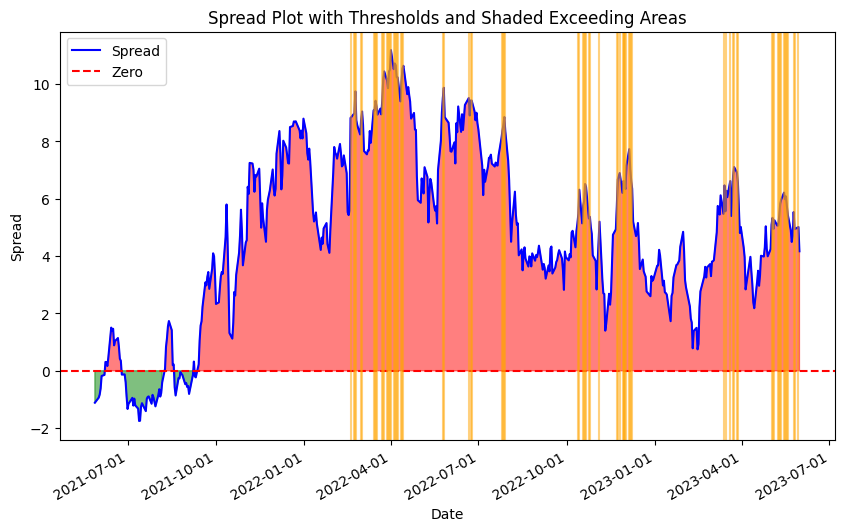

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 152
Total number of days: 505
Winning percentage: 30.10%
Total number of trades: 11

Cummulative return: -28.74672
Sharpe ratio: -1.33436
Sortino ratio: -0.10902
Max drawdown: -30.32601


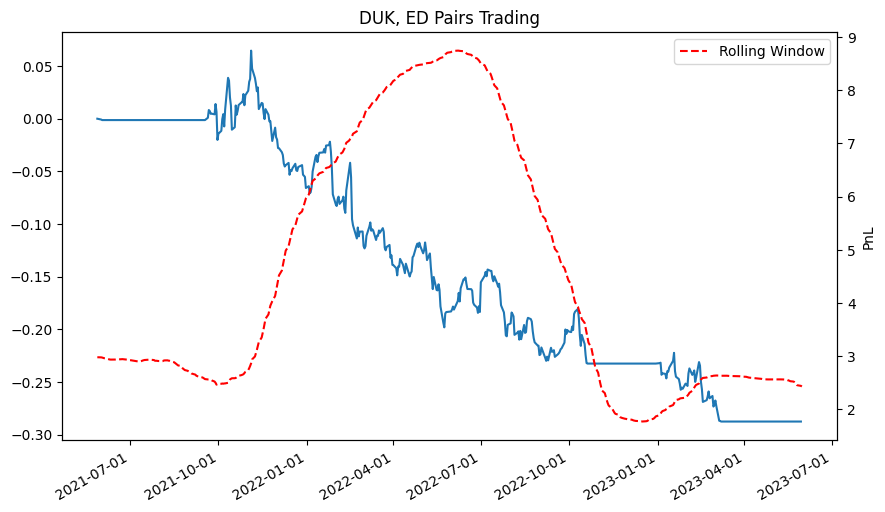

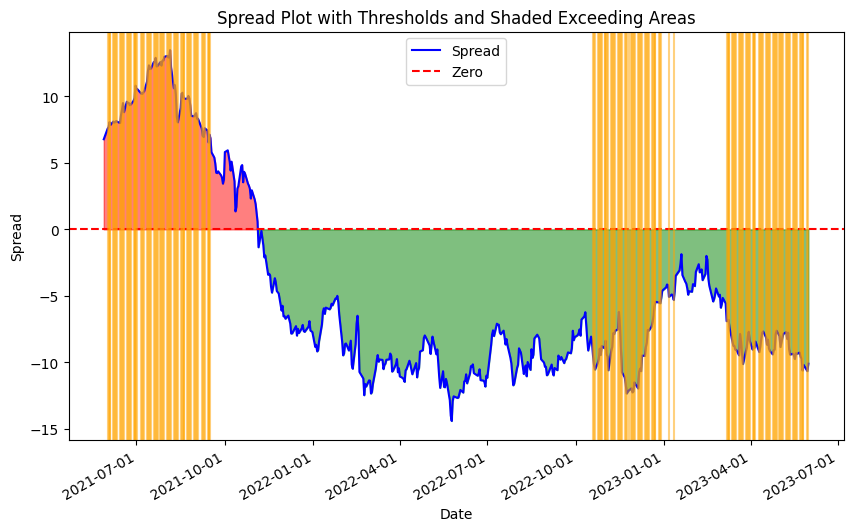

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 253
Total number of days: 505
Winning percentage: 50.10%
Total number of trades: 47

Cummulative return: -1.94917
Sharpe ratio: -0.06705
Sortino ratio: -0.00581
Max drawdown: -23.15648


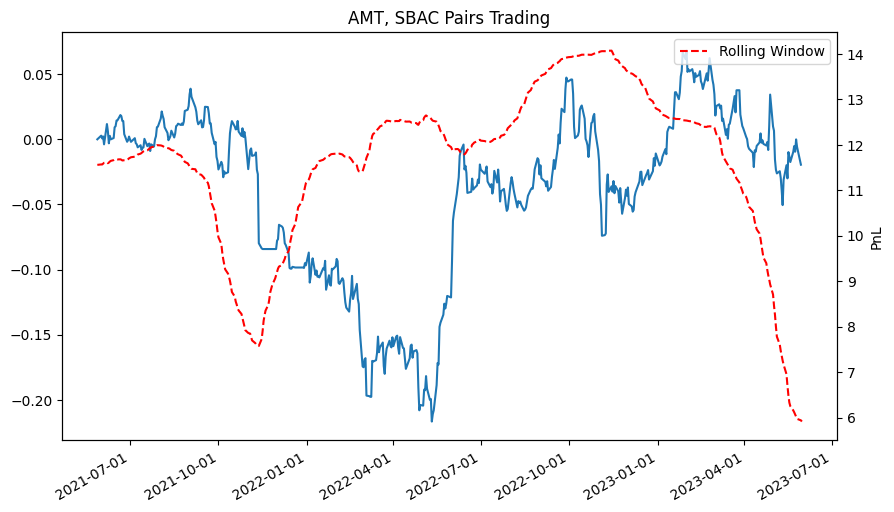

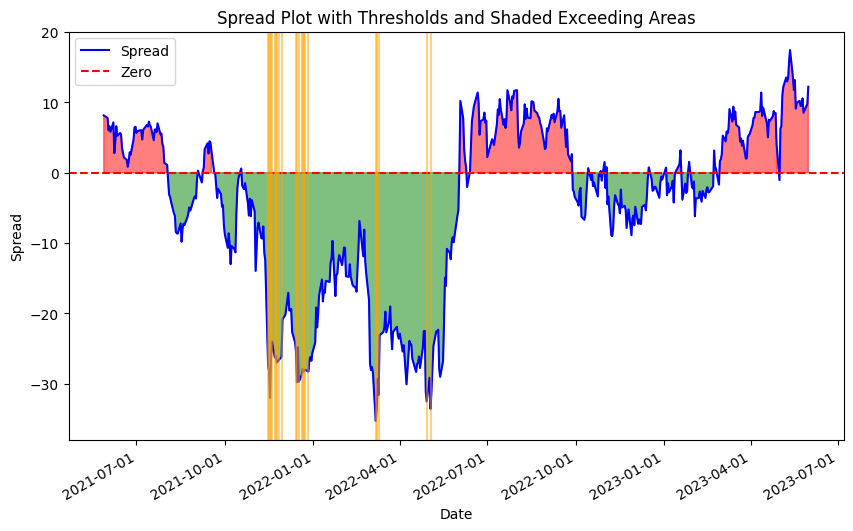

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 259
Total number of days: 505
Winning percentage: 51.29%
Total number of trades: 46

Cummulative return: 30.47096
Sharpe ratio: 0.64872
Sortino ratio: 0.05862
Max drawdown: -17.19710


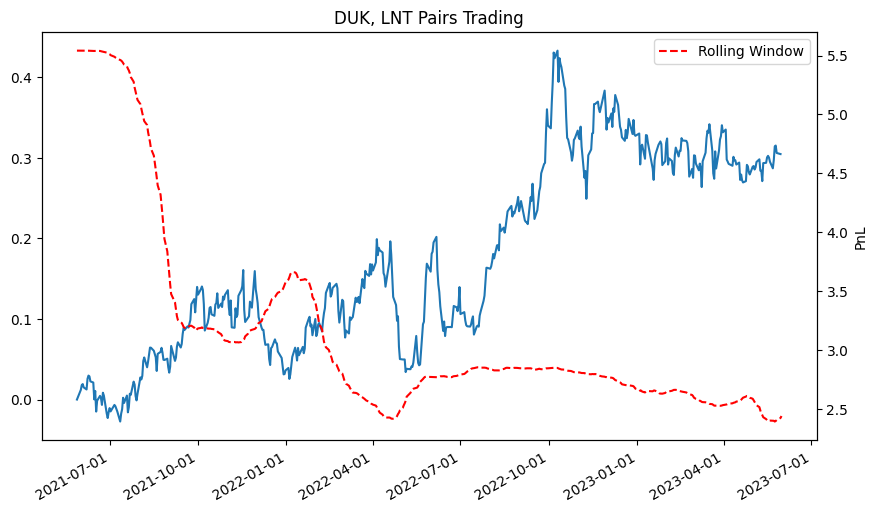

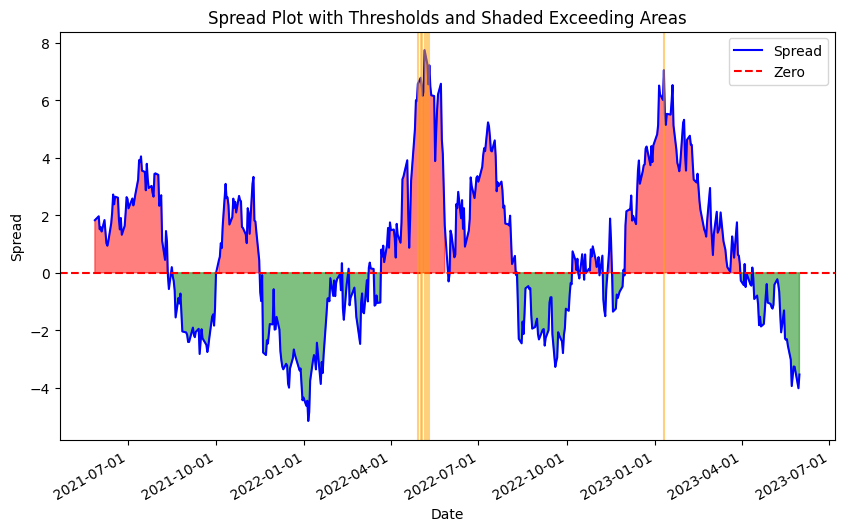

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 248
Total number of days: 505
Winning percentage: 49.11%
Total number of trades: 31

Cummulative return: 17.60003
Sharpe ratio: 0.41939
Sortino ratio: 0.03823
Max drawdown: -18.51848


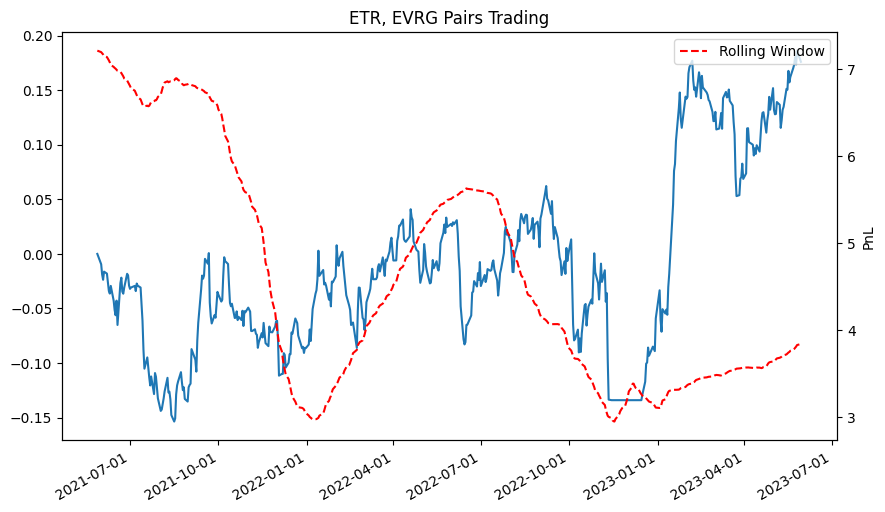

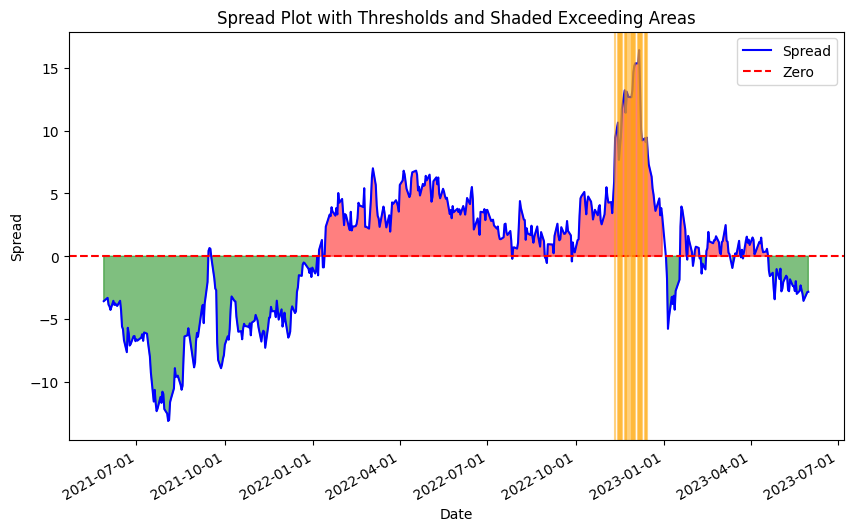

Last occurrence of NaN values in 'spread_rolling_std': 2021-05-28 00:00:00

***** FINANCIAL PERFORMANCE *****

ROLLING OLS Regression with 252

Number of winning days: 252
Total number of days: 505
Winning percentage: 49.90%
Total number of trades: 38

Cummulative return: -9.33875
Sharpe ratio: -0.10642
Sortino ratio: -0.00931
Max drawdown: -51.62711


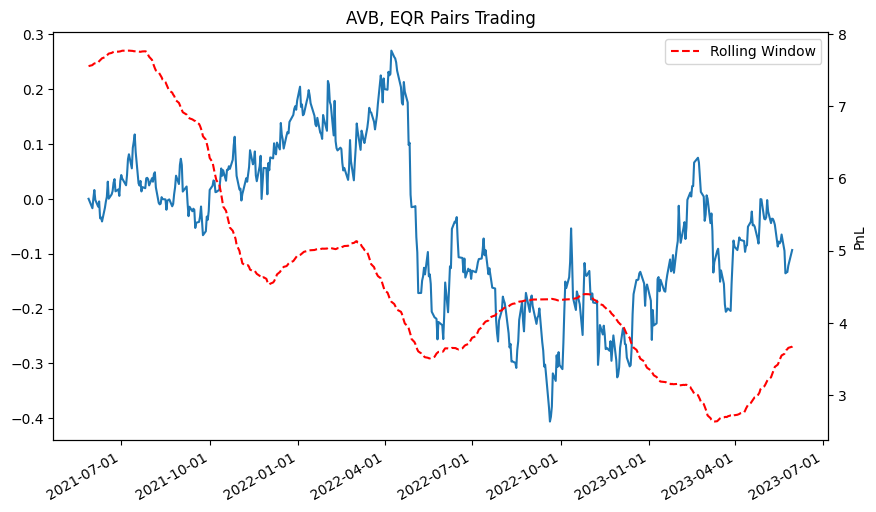

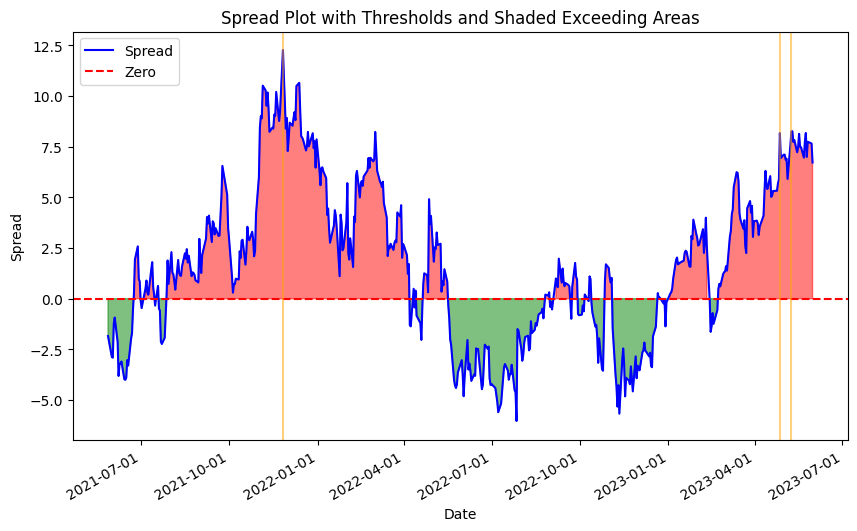

In [83]:
for i in range(len(dyon_pairs)):
    df = ROLLING_OLS(dyon_pairs['Pair 1'][i], dyon_pairs['Pair 2'][i])
    df